In [18]:
# 推定量の一致性と不偏性の確認
#
# 2015/06/01 ver1.0
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from pandas import Series, DataFrame
from numpy.random import normal
%matplotlib inline

In [4]:
N=10            # サンプルを取得する位置 x の個数
M=[0,1,3,9]     # 多項式の次数


In [5]:
# データセット {x_n,y_n} (n=1...N) を用意
def create_dataset(num):
    dataset = DataFrame(columns=['x','y'])
    for i in range(num):
        x = float(i)/float(num-1)
        y = np.sin(2*np.pi*x) + normal(scale=0.3)
        dataset = dataset.append(Series([x,y], index=['x','y']),
                                 ignore_index=True)
    return dataset

In [6]:
# 平方根平均二乗誤差（Root mean square error）を計算
def rms_error(dataset, f):
    err = 0.0
    for index, line in dataset.iterrows():
        x, y = line.x, line.y
        err += 0.5 * (y - f(x))**2
    return np.sqrt(2 * err / len(dataset))


In [3]:
# 最小二乗法で解を求める
def resolve(dataset, m):
    t = dataset.y
    phi = DataFrame()
    for i in range(0,m+1):
        p = dataset.x**i
        p.name="x**%d" % i
        phi = pd.concat([phi,p], axis=1)
    tmp = np.linalg.inv(np.dot(phi.T, phi))
    ws = np.dot(np.dot(tmp, phi.T), t)

    def f(x):
        y = 0
        for i, w in enumerate(ws):
            y += w * (x ** i)
        return y

    return (f, ws)


In [8]:
train_set = create_dataset(N)
train_set.tail()

,x,y
5,0.555556,-0.341825
6,0.666667,-0.702253
7,0.777778,-1.122032
8,0.888889,-1.414048
9,1.000000,0.055326


In [9]:
test_set = create_dataset(N)
test_set.tail()

,x,y
5,0.555556,-0.469578
6,0.666667,-1.153547
7,0.777778,-0.489982
8,0.888889,-1.085632
9,1.000000,0.031396


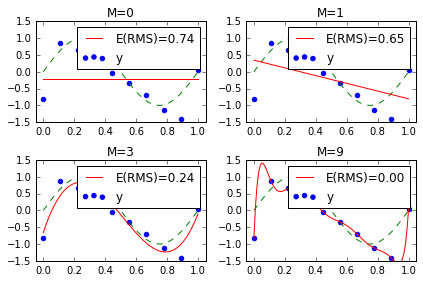

In [11]:
df_ws = DataFrame()
fig = plt.figure()
for c, m in enumerate(M):
    f, ws = resolve(train_set, m)
    df_ws = df_ws.append(Series(ws,name="M=%d" % m))

    subplot = fig.add_subplot(2,2,c+1)
    subplot.set_xlim(-0.05,1.05)
    subplot.set_ylim(-1.5,1.5)
    subplot.set_title("M=%d" % m)

    # トレーニングセットを表示
    subplot.scatter(train_set.x, train_set.y, marker='o', color='blue')

    # 真の曲線を表示
    linex = np.linspace(0,1,101)
    liney = np.sin(2*np.pi*linex)
    subplot.plot(linex, liney, color='green', linestyle='--')

    # 多項式近似の曲線を表示
    linex = np.linspace(0,1,101)
    liney = f(linex)
    label = "E(RMS)=%.2f" % rms_error(train_set, f)
    subplot.plot(linex, liney, color='red', label=label)
    subplot.legend(loc=1)

plt.tight_layout()

In [19]:
# 係数の値を表示
df_ws.T

,M=0,M=1,M=3,M=9
0,-0.228665,0.346303,-0.659563,-0.824286
1,NaN,-1.149937,13.932676,111.651020
2,NaN,NaN,-38.071341,-1976.964968
3,NaN,NaN,24.696113,15741.069942
4,NaN,NaN,NaN,-68187.879800
5,NaN,NaN,NaN,174227.080605
6,NaN,NaN,NaN,-270285.224218
7,NaN,NaN,NaN,250316.990526
8,NaN,NaN,NaN,-127313.519377
9,NaN,NaN,NaN,27367.675106


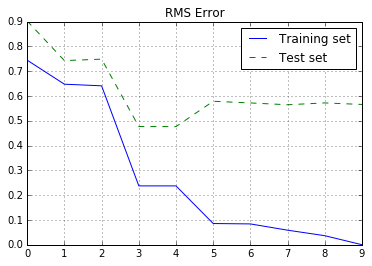

In [17]:
# トレーニングセットとテストセットでの誤差の変化を表示
df = DataFrame(columns=['Training set','Test set'])
for m in range(0,10):   # 多項式の次数
    f, ws = resolve(train_set, m)
    train_error = rms_error(train_set, f)
    test_error = rms_error(test_set, f)
    df = df.append(
            Series([train_error, test_error],
                index=['Training set','Test set']),
            ignore_index=True)
df.plot(title='RMS Error', style=['-','--'], grid=True, ylim=(0,0.9))